
# ISAX for similarity search
THis is a simple implementation of the iSAX: Indexing and Mining Terabyte Sized Time Series [paper](http://www.cs.ucr.edu/~eamonn/iSAX.pdf).

This is a basic simplfied implementation which was inspired by the work done by "luk-f" on [github](https://github.com/luk-f/SAX) for EGC.

we kept the same basic structure but modified the some methods to fit our needs,
we also addded detailed comments, and fixed some bugs.


In [1]:
import numpy as np
import difflib
from numpy import array as np_array
from numpy import arange as np_arange
from numpy import sqrt
from numpy import average
from copy import deepcopy
from scipy.spatial.distance import euclidean as d_eucli

from queue import PriorityQueue as pqueue

from scipy.stats import norm
np.random.seed(0)

# Basic encoding functions:
## PAA
PAA, or piecewise aggregate approximation is a method that uses segment means of a time series to reduce its dimension, in our implementation we don't take into account time series of different size (different dimension), so we only need to implement a simple function ts_to_paa that will map a time series to the means of its segments.
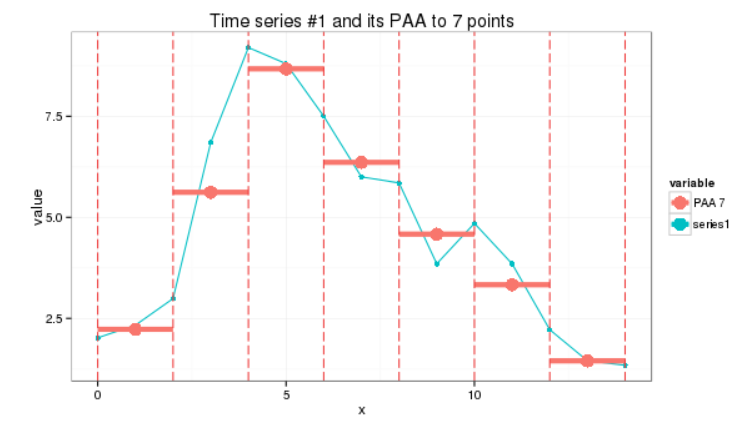

In [2]:
def ts_to_paa(time_serie,reduced_size):
  step = int(len(time_serie) / reduced_size)
  reduced = []
  for i in range(0, len(time_serie), step):
    start = i
    end = i + step
    letter = np.average(time_serie[start:end])
    reduced.append(letter)

  return reduced


# we also define de reverse function

def paa_to_ts(paa_time_serie, segment_size):
    original_ts = []
    for i in paa_time_serie:
        for j in range(int(segment_size)):
            original_ts.append(i)
            
    return original_ts


# we also implement a way to apply on lists 
def list_paa_to_list_ts(list_paa_ts, segment_size):
    list_ts =[]
    for i in range(len(list_paa_ts)):
        list_ts.append(paa_to_ts(list_paa_ts[i], segment_size))
        
    return list_ts

def list_ts_to_list_paa(list_time_serie,size_word):
    list_paa = []
    for i in range(len(list_time_serie)):
        list_paa.append( ts_to_paa(list_time_serie[i], size_word))
    return list_paa



# we can also count the reconstruction error of our lists 

def reconstruction_error(orig, reconstructed):
    return d_eucli(orig, reconstructed)

def list_reconstruction_error(list_orig, list_reconstruct):
    errors = []
    for i in range(len(list_orig)):
        errors.append(reconstruction_error(list_orig[i], list_reconstruct[i]))
    return errors
    

## SAX
Sax is the next step after PAA reduction, it simply map each paa value to a sax letter based on where it appearese on a graph using predefined breakpoints, a concrete exemple:
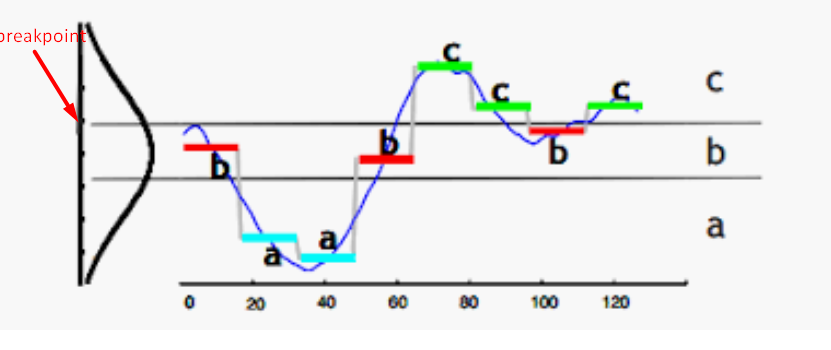

breakpoints are defined using a gaussian distribution, each sax letter has to have the same probability over a gaussian distribution

In [3]:
def sax(time_serie,size_word,breakpoints):

    sax_word = []
    paa_word = ts_to_paa(time_serie, size_word)
    for paa_letter in paa_word:
        sax_word.append(paa_to_sax(paa_letter,breakpoints))

    return paa_word, sax_word

#encode one value to a sax letter based on breakpoints
def paa_to_sax(value,breakpoints):
    sax = 0
    for var in breakpoints:
        if value < var:
            break
        sax += 1
    return sax

  
# the class used to find the breakpoints based on the isax letter cardinality
class NormalGaussian:

    normalBreakpointsByCardinality = {}
    breakpointsByCardinality = {}

    def __init__(self, mean, std):

        self.mean = mean
        self.std = std

    def getBreakpointsByCardinality(self, cardinality): # this function return the breakpoints based on cardinality
                                                        # we do not process cases that we haven't seen before, and we store already seen case to avoid processing the same thing multiple timess

        if cardinality not in self.breakpointsByCardinality:
            frac = 1.0/cardinality
            list_percent = []
            for i_fl in np_arange(frac, 1.0, frac):
                list_percent.append(i_fl)
            self.breakpointsByCardinality[cardinality] = (np_array(norm.ppf(list_percent))*self.std+self.mean)
        return self.breakpointsByCardinality[cardinality]

# Index Tree class
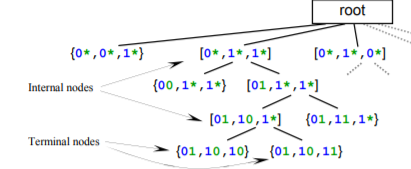

In [4]:
class Tree:

    def __init__(self,paa_segment_size,threshold,data_ts,base_cardinality=2):
        
        self.paa_segment_size = paa_segment_size
  
        self.threshold = threshold #the max number of time series in a leaf node

        self.base_cardinality = base_cardinality # the base cardinality of our letter, this simply means that our sax words for our first level internal nodes will use 3 breakpoints (4 letters)
        
        self.root = RootNode(self,[base_cardinality] * paa_segment_size) # we construct the rootnode and define the word cardinality of its futur children
        
        self.mu, self.sig = norm.fit(data_ts)
        self.bkpt = NormalGaussian(self.mu, self.sig) #we build our breakpoints generator

    def insert(self,new_timeserie):
      self.root.insert(new_timeserie)

            

    def insertMultiple(self, new_timeseries):
       for i in new_timeseries:
         self.root.insert(i)


    def exactSearch(self,new_timeserie):
      return self.root.exactSearch(new_timeserie)

    def exactRefinedSearch(self,new_timeserie):
      return self.root.exactRefinedSearch(new_timeserie)


# THe ISAX tree Nodes
## the Root node
the root node is the heart of the tree and all the other nodes heritate the root node, it has 3 attributes:
  - a pointer to the tree it is currently in
  - cardinality_next : the words cardinality of its children
  - nodes : a hashmap (string, Rootnode) containing the list of its child nodes
  using their isax word as key.

The root node contain 6 functions we commented below
we build the tree by inserting our dataset time series one by one from the root node, each time the thresh hold is exceeded in a specific leaf, we split the leaf and double the cardinality of one of its letters in its child node

the most interresting function is probably the mindist_PAA_iSAX it is used to get the distance from a time series and an isax word, based on the original paper :
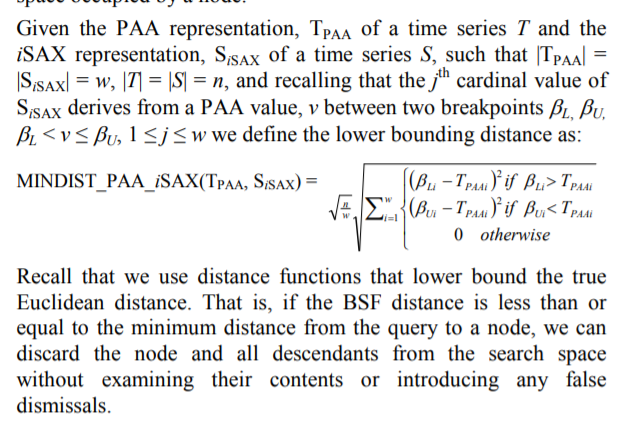

In [5]:
class RootNode:

    def __init__(self, arbre, cardinality_next):

        self.arbre = arbre  # pointer to tree
        self.cardinality_next = cardinality_next # word cardinality of children default cardinality_next for rootNode = [2, 2, 2, 2...] (as much as paa length)  
        self.terminal = False

        self.nodes = {}

        
        
    def __lt__(self, y):
        return True

    """
     inserting a new time series in the tree)
    """
    def insert(self, new_timeserie): 


        iSAX_word = self.iSAX_next(new_timeserie) # we define the  isax word of the time serie we want to insert based on the cardinality of children nodes words.

        
        # we check if a child node in the child node list has the same word encoding as the time serie we want to insert
        if str([i[0] for i in iSAX_word]) in self.nodes:

          #if it exists, we retrieve it
            current_node = self.nodes[str([i[0] for i in iSAX_word])]

            # we check if the retrieved node is terminal (is a leaf node)
            if current_node.terminal:

              # if the node is a leaf node and inserting won't make us exceed the threshold, we insert the new time serie to its list of time series
              # however, if it exceeds the threshold, we replace this node by an internal node with the same isax word and cardinalities, and we insert all
              # the time series from the leaf node in this new node recursively
                if (current_node.nb_timeseries) < self.arbre.threshold:
                    current_node.insert(new_timeserie)
                    
                else:
                    new_node = InternalNode(self.arbre, current_node.parent, deepcopy(current_node.sax),
                                            deepcopy(current_node.cardinality),current_node.timeseries)
                    
                    new_node.insert(new_timeserie)
                    
                    for ts in current_node.timeseries:
                        new_node.insert(ts)
                        
                    del self.nodes[str(current_node.sax)]
                    
                    self.nodes[str(current_node.sax)] = new_node
                    
                    current_node.parent = None
                    
                    del current_node
            else:
                
                current_node.insert(new_timeserie)
        #If we don't find any node with the same isax word as the time serie we want to insert, we simply insert a new leaf node and insert our time serie into it        
        else:

            new_node = TerminalNode(self.arbre, self, [i[0] for i in iSAX_word], self.cardinality_next)
            
            new_node.insert(new_timeserie)
            
            self.nodes[str([i[0] for i in iSAX_word])] = new_node

    # encode our time serie into an isax word based on the cardinalities of the children nodes
    def iSAX_next(self, new_timeserie):

        paa_word = ts_to_paa(new_timeserie, self.arbre.paa_segment_size) # paa reduction based on segment size
        iSAX_word = []

        for i in range(len(paa_word)):                                                      #for each paa segment index
            current_card = self.cardinality_next[i]                                         # get the corresponding isax letter cardinality of child node
            iSAX_letter = -1                                                                # initialize the isax letter of this segment to -1
            current_breakpoints = self.arbre.bkpt.getBreakpointsByCardinality(current_card) # get all the breakpoints corresponding to the segment cardinality
            iSAX_letter = paa_to_sax(paa_word[i],current_breakpoints)                       # encode the current paa segment value to isax letter based on retrieved breakpoints
            iSAX_word.append([iSAX_letter, current_card])                                   # append it to the final isax word
        return iSAX_word



    # function used to get the distance from a time serie and an isax word
    def mindist_PAA_iSAX(self, ts, s_isax):
        result = 0
        t_paa = ts_to_paa(ts, self.arbre.paa_segment_size)        #reduce time series to paa


        
        s_sax = [i[0] for i in s_isax]      #isax word
        s_card = [i[1] for i in s_isax]     # isax letters cardinalities

        if len(t_paa) == len(s_sax):
            n = len(ts)
            w = len(t_paa)


            for i in range(w):
                b_Li = float("-inf")
                b_Ui = float("inf")
                list_brkpt = sorted(self.arbre.bkpt.getBreakpointsByCardinality(s_card[i])) # get list of breakpoints
                

                # here we check calculate the distance from isax word, refer to text above for more details
                if s_sax[i] > 0:
                    b_Li = list_brkpt[s_sax[i] - 1]

                if s_sax[i] < len(list_brkpt):
                    b_Ui = list_brkpt[s_sax[i]]
     

                if t_paa[i] < b_Li:
                    result += (b_Li - t_paa[i]) * (b_Li - t_paa[i])
                elif t_paa[i] > b_Ui:
                    
                    result += (b_Ui - t_paa[i]) * (b_Ui - t_paa[i])
            result = sqrt(result)
            result *= sqrt(n / w)

            return result
        else:
            print("Erreur len(t_paa) =/= len(s_isax)");
            return -1

    def exactSearch(self, new_timeserie):

        bestsofar_index = self.approximateSearch(new_timeserie) # return the leaf containing the best so far closest time series from query

        bestsofar_dist, st_min, n_checked_temp = self.indexFileDist(new_timeserie, bestsofar_index)  # find the best so far closest time serie and its distance from query

        n_checked_ts = n_checked_temp
        # we will now check if there exist another node which is closer from our query than our best so far distance

        pq = pqueue()
        pq.put((0, self)) # we will use a priority queue and insert nodes one by one sorted by their distance from the query, we give
                          # a distance of 0 to the root node to avoid to break on the first check and check its children nodes

        while not pq.empty():  # while priority queue is not empty we further check
            min = pq.get()
            if min[0] >= bestsofar_dist: # if the distance from the node is greater from the best so far, we just skip this node and all 
                                         # the time series that it contains
                break
            if min[1].terminal: #if the node that has a distance from query smaller than the best so far
                                # there could be  a time serie in this node which has an even smaller distance from query and we need to retrieve it 
                                # and define it as current best so far
                tmp, tstemp, n_checked_temp = self.indexFileDist(new_timeserie, min[1])
                
                n_checked_ts += n_checked_temp
                
                if bestsofar_dist > tmp:
                    bestsofar_dist = tmp
                    st_min = tstemp
                    bestsofar_index = min[1]
            else:  #if the current node isn't a leaf node we add all its child node and their distance from query to priority queue
                for sax, child_node in min[1].nodes.items():
                    node_dist = self.mindist_PAA_iSAX(new_timeserie,child_node.iSAX_word)
                    pq.put((node_dist, child_node))

        return bestsofar_index, st_min, n_checked_ts
  
    
    # get the approximatly closest time serie from our query
    def approximateSearch(self, new_timeserie):
        n_ts_isax = self.iSAX_next(new_timeserie) # encode our current time serie into isax word based on cardinalities of children nodes
        if str([i[0] for i in n_ts_isax]) in self.nodes:
            return self.nodes[str([i[0] for i in n_ts_isax])].approximateSearch(new_timeserie)
        else:
            first = next(iter(self.nodes))
            return self.nodes[first].approximateSearch(new_timeserie)



    #return the closest time serie from a query (ts), and its distance
    # only used on terminal (leaf) nodes
    def indexFileDist(self, ts, node):

        dist_min = float('inf')
        st_min = None
        n_checked_ts = len(node.timeseries) ## number of checked timeseries, will be used for pruning ratio
        for ts_node in node.timeseries: # for each time serie in the list of time series)
            diff = d_eucli(ts,ts_node)  # count the euclidean distance from the query

            if diff < dist_min:         # get the smallest
                dist_min = diff
                st_min = ts_node
        return dist_min, st_min, n_checked_ts


        

    # function used to get the distance from a time serie and an isax word without PAA
    def mindist_ORIG_iSAX(self, ts, s_isax):
        result = 0
        t_paa = ts_to_paa(ts, self.arbre.paa_segment_size)        #reduce time series to paa


        
        s_sax = [i[0] for i in s_isax]      #isax word
        s_card = [i[1] for i in s_isax]     # isax letters cardinalities
        step = int(len(ts)/self.arbre.paa_segment_size)
        n = len(ts)
        w = len(t_paa)

        for i in range(w):
            b_Li = float("-inf")
            b_Ui = float("inf")
            list_brkpt = sorted(self.arbre.bkpt.getBreakpointsByCardinality(s_card[i])) # get list of breakpoints
            # here we check calculate the distance from isax word, refer to text above for more details
            if s_sax[i] > 0:
                b_Li = list_brkpt[s_sax[i] - 1]

            if s_sax[i] < len(list_brkpt):
                b_Ui = list_brkpt[s_sax[i]]
                     
            start = i*step
            end = (i+1)*step
            for j in range(start,end):
                if ts[j] < b_Li:
                     result += (b_Li - ts[j]) * (b_Li - ts[j])
                elif ts[j] > b_Ui:
                    result += (b_Ui - ts[j])*(b_Ui - ts[j])        
        result = sqrt(result)
        result *= sqrt(n / n)

        return result

    def exactRefinedSearch(self, new_timeserie):

        bestsofar_index = self.approximateSearch(new_timeserie) # return the leaf containing the best so far closest time series from query

        bestsofar_dist, st_min, n_checked_temp = self.indexFileDist(new_timeserie, bestsofar_index)  # find the best so far closest time serie and its distance from query

        n_checked_ts = n_checked_temp
        # we will now check if there exist another node which is closer from our query than our best so far distance

        pq = pqueue()
        pq.put((0, self)) # we will use a priority queue and insert nodes one by one sorted by their distance from the query, we give
                          # a distance of 0 to the root node to avoid to break on the first check and check its children nodes

        while not pq.empty():  # while priority queue is not empty we further check
            min = pq.get()
            if min[0] >= bestsofar_dist: # if the distance from the node is greater from the best so far, we just skip this node and all 
                                         # the time series that it contains
                break
            if min[1].terminal: #if the node that has a distance from query smaller than the best so far
                                # there could be  a time serie in this node which has an even smaller distance from query and we need to retrieve it 
                                # and define it as current best so far
                tmp, tstemp, n_checked_temp = self.indexFileDist(new_timeserie, min[1])
                
                n_checked_ts += n_checked_temp
                
                if bestsofar_dist > tmp:
                    bestsofar_dist = tmp
                    st_min = tstemp
                    bestsofar_index = min[1]
            else:  #if the current node isn't a leaf node we add all its child node and their distance from query to priority queue
                for sax, child_node in min[1].nodes.items():
                    node_dist = self.mindist_ORIG_iSAX(new_timeserie,child_node.iSAX_word)
                    pq.put((node_dist, child_node))

        return bestsofar_index, st_min, n_checked_ts
  


## internal node
heritate from root node, it also has a differente constructor and a  sax word and cardinality that defines it, we process the cardinalities of its child node by just doubling the smallest cardinality from the parent cardinality.

we also add a get_timeseries function that get the time series of child nodes

In [6]:

class InternalNode(RootNode):
    def __init__(self, arbre, parent, sax, cardinality, timeseries):

        self.iSAX_word = []
        
        for i in range(len(sax)):
            self.iSAX_word.append([sax[i], cardinality[i]])


        self.arbre = arbre
        self.sax = sax
        self.cardinality = cardinality

        
        # position_min = self.cardinality.index(min(self.cardinality))

        min_indexes = [i for i, x in enumerate(self.cardinality) if x == min(self.cardinality)]
        self.cardinality_next = deepcopy(self.cardinality)


        self.cardinality_next[np.random.choice(min_indexes)] *= 2

        self.nodes = {}
        self.parent = parent
        self.terminal = False

    def getTimeseries(self):
        timeseries = []
        for key, _ in self.nodes.items():
            for ts in self.nodes[key].getTimeseries():
                timeseries.append(ts)
        return timeseries


## terminal (leaf) Node

heritate from root node, we add a timeseries list which will contains the timeseries contained in this leaf (or their index).
we also redefine: 
- the insert function, here we directly insert the timeserie in parameter to    the timeseries list 
- the approximatesearch function : here we only return the node itself

we add a get time series function which is simply a getter for the list of time series .

In [7]:

class TerminalNode(RootNode):

    def __init__(self, arbre, parent, sax, cardinality):
        self.iSAX_word = []
        for i in range(len(sax)):
            self.iSAX_word.append([sax[i], cardinality[i]])


        self.arbre = arbre
        self.sax = sax
        self.cardinality = cardinality
        self.cardinality_next = None

        self.nb_timeseries = 0

        self.timeseries = []

        self.terminal = True
        self.parent = parent

    def insert(self, ts):
        self.timeseries.append(ts)
        self.nb_timeseries += 1

    def approximateSearch(self, new_timeserie):
        return self

    def getTimeseries(self):
        return self.timeseries

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import csv

# Input data files are available in the "../input/" directory.

## initializing paths
inputFolderPath = '/kaggle/input/similarity-search-project/'
outputFolderPath = '/kaggle/working/'


inputFilePath_synthetic = inputFolderPath + 'synthetic_size50k_len256_znorm.bin'
inputFilePath_seismic = inputFolderPath + 'seismic_size50k_len256_znorm.bin'

queryFilePath_synthetic = inputFolderPath + 'synthetic-query_size100_len256_znorm.bin'
queryFilePath_seismic = inputFolderPath + 'seismic-query_size100_len256_znorm.bin'


# data reduction with paa
In the isax method, the reduction method used is paa, we implemented the function asked but this is not necessary to build the tree, those functions won't be used next

In [9]:
########################## summarization and reconstruction functions ################################################
def sum32(inputFilePath):
    """ Summurizes 50k 256*float32 time series read from a binary file to 50k 32-bytes summaries 
    
    Parameters: 
    inputFilePath (string): the path of the binary file containing the 50k time series to summarize
  
    Returns: 
    string: the path of the binary file of the 50k summaries

    """

    summary_filepath =  outputFolderPath + filename + '_sum32'    
    ##############################################################################
    ##change the following code for 32-bytes summarization 
    
    #read binary file
    time_series50k = np.fromfile(inputFilePath, dtype=np.float32).reshape(-1, 256)
        
    summary50k = []
    #dummy summarization(picking the first value to summarize the hole series)
    for time_series in time_series50k:
        summary50k.append(ts_to_paa(time_series,8))
    
    #write the result in a binary file, then return the output file path
    summary50knp = np.array(summary50k,dtype=np.float32)
    summary50knp.tofile(summary_filepath)    

    ##############################################################################
    return summary_filepath

def rec32(summary_filepath):
    """ reconstructs 50k 256*float32 time series based on 50k 32-bytes summaries read from binary file
    
    Parameters: 
    summary_filepath (string): the path of the binary file containing the 50k 32-bytes summaries
  
    Returns: 
    string: the path of the binary file of the 50k reconstructed time series
    """
    reconstructed_filepath = summary_filepath + '_rec32'

    ##############################################################################
    ##change the following code for reconstruction from 32-bytes summaries 
    
    #read binary file
    summary50k = np.fromfile(summary_filepath, dtype=np.float32)

    reconstructed50k = []
    #dummy reconstruction (duplicating single float32 value 256 times)
    for summary in summary50k:
        reconstructed50k.append(paa_to_ts(summary, 32))
    
    #write the result in a binary file, then return the output file path
    reconstructed50knp = np.array(reconstructed50k,dtype=np.float32)
    reconstructed50knp.tofile(reconstructed_filepath) 

    ##############################################################################
    return reconstructed_filepath
    

def sum64(inputFilePath):
    """ Summurizes 50k 256*float32 time series read from a binary file to 50k 64-bytes summaries 
    
    Parameters: 
    inputFilePath (string): the path of the binary file containing the 50k time series to summarize
  
    Returns: 
    string: the path of the binary file of the 50k summaries

    """

    summary_filepath =  outputFolderPath + filename + '_sum64'    
    ##############################################################################
    ##change the following code for 64-bytes summarization 
    
    #read binary file
    time_series50k = np.fromfile(inputFilePath, dtype=np.float32).reshape(-1, 256)
        
    summary50k = []
    #dummy summarization(picking the first value to summarize the hole series)
    for time_series in time_series50k:
        summary50k.append(ts_to_paa(time_series,16))
    
    #write the result in a binary file, then return the output file path
    summary50knp = np.array(summary50k,dtype=np.float32)
    summary50knp.tofile(summary_filepath)    

    ##############################################################################
    return summary_filepath

def rec64(summary_filepath):
    """ reconstructs 50k 256*float32 time series based on 50k 64-bytes summaries read from binary file
    
    Parameters: 
    summary_filepath (string): the path of the binary file containing the 50k 64-bytes summaries
  
    Returns: 
    string: the path of the binary file of the 50k reconstructed time series
    """
    reconstructed_filepath = summary_filepath + '_rec64'

    ##############################################################################
    ##change the following code for reconstruction from 64-bytes summaries 
    
    #read binary file
    summary50k = np.fromfile(summary_filepath, dtype=np.float32).reshape(-1, 2)

    reconstructed50k = []
    #dummy reconstruction (duplicating the first single float32 value 256 times)
    for summary in summary50k:
        reconstructed50k.append(paa_to_ts(summary, 16))
    
    #write the result in a binary file, then return the output file path
    reconstructed50knp = np.array(reconstructed50k,dtype=np.float32)
    reconstructed50knp.tofile(reconstructed_filepath) 

    ##############################################################################
    return reconstructed_filepath
    

def sum128(inputFilePath):
    """ Summurizes 50k 256*float32 time series read from a binary file to 50k 128-bytes summaries 
    
    Parameters: 
    inputFilePath (string): the path of the binary file containing the 50k time series to summarize
  
    Returns: 
    string: the path of the binary file of the 50k summaries

    """

    summary_filepath =  outputFolderPath + filename + '_sum128'    
    ##############################################################################
    ##change the following code for 128-bytes summarization 
    
    #read binary file
    time_series50k = np.fromfile(inputFilePath, dtype=np.float32).reshape(-1, 256)
        
    summary50k = []
    #dummy summarization(picking the first value to summarize the hole series)
    for time_series in time_series50k:
        summary50k.append(ts_to_paa(time_series,32))
        
    #write the result in a binary file, then return the output file path
    summary50knp = np.array(summary50k,dtype=np.float32)
    summary50knp.tofile(summary_filepath)    

    ##############################################################################
    return summary_filepath

def rec128(summary_filepath):
    """ reconstructs 50k 256*float32 time series based on 50k 128-bytes summaries read from binary file
    
    Parameters: 
    summary_filepath (string): the path of the binary file containing the 50k 128-bytes summaries
  
    Returns: 
    string: the path of the binary file of the 50k reconstructed time series
    """
    reconstructed_filepath = summary_filepath + '_rec128'

    ##############################################################################
    ##change the following code for reconstruction from 128-bytes summaries 
    
    #read binary file
    summary50k = np.fromfile(summary_filepath, dtype=np.float32).reshape(-1, 4)

    reconstructed50k = []
    #dummy reconstruction (duplicating the first single float32 value 256 times)
    for summary in summary50k:
        reconstructed50k.append(paa_to_ts(summary, 8))
    
    #write the result in a binary file, then return the output file path
    reconstructed50knp = np.array(reconstructed50k,dtype=np.float32)
    reconstructed50knp.tofile(reconstructed_filepath) 

    ##############################################################################
    return reconstructed_filepath

# Similarity search
for the similarity search on the two dataset, we chose as a parameter for building our tree an 8 segment size (the 32 byte reduction) with a threshold of 256 time series per leaf node, we don't need a bigger segment size because the total possible number of representation on the first level of the tree (number of possible first level node) is equal to 2^segment_size.
meaning that if we double the segment size we will have 2^16, which is way bigger than our dataset of 50k time series.

In [10]:
########################## similarity search ################################################


def similarity():
    """ calculate the average pruning ratio of similarity search in two datasets of 50k time series series
    
    Parameters: 
    
  
    Returns: 
    float: the pruning ratio averaged over all the 100 queries from both datasets. it must be between 0 and 1 (exluded)

    """
    time_series50k_seismic = np.fromfile(inputFilePath_seismic, dtype=np.float32).reshape(-1, 256)
    time_series50k_synthetic = np.fromfile(inputFilePath_synthetic, dtype=np.float32).reshape(-1, 256)
    time_series100_query_synthetic = np.fromfile(queryFilePath_synthetic, dtype=np.float32).reshape(-1, 256)
    time_series100_query_seismic = np.fromfile(queryFilePath_seismic, dtype=np.float32).reshape(-1, 256)
    
    # build isax tree
    tree_seismic = Tree(paa_segment_size=8, threshold=256, data_ts=time_series50k_seismic)
    tree_synthetic = Tree(paa_segment_size=8, threshold=256, data_ts=time_series50k_synthetic)
    #insert time_series in tree
    tree_seismic.insertMultiple(time_series50k_seismic)
    tree_synthetic.insertMultiple(time_series50k_synthetic)
    
    pruning_ratios = []
    len_seismic = len(time_series50k_seismic)
    len_synthetic = len(time_series50k_synthetic)
    
    for query in time_series100_query_seismic:
        result = tree_seismic.exactSearch(query)
        pruned = len_seismic - result[2]
        if pruned < 0:
            pruned = 0
        pruning_ratios.append(pruned/len_seismic)
        
    t = 0
    for query in time_series100_query_synthetic:
        result = tree_synthetic.exactSearch(query)
        pruned = len_synthetic - result[2]
        if pruned < 0:
            pruned = 0
        pruning_ratios.append(pruned/len_synthetic)


    average_prune_ratio = np.average(pruning_ratios)
    
    return average_prune_ratio

In [11]:
########################## Submission ################################################
############ follow this templateand do not modify this cell code ####################

#call of similatrity search function 
average_prune_ratio = similarity()

print(average_prune_ratio)

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id','expected'])
    writer.writerow(['1',average_prune_ratio])

0.49806110000000003


# ISAX Big flaw ?


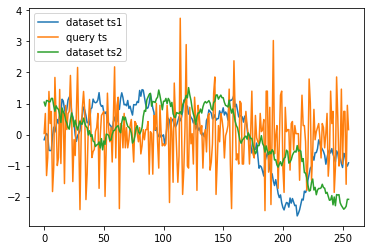

In [12]:
import matplotlib.pyplot as plt

time_series50k_synthetic = np.fromfile(inputFilePath_synthetic, dtype=np.float32).reshape(-1, 256)
time_series100_query_synthetic = np.fromfile(queryFilePath_synthetic, dtype=np.float32).reshape(-1, 256)

plt.plot(range(len(time_series100_query_synthetic[1])),time_series50k_synthetic[1], label="dataset ts1")
plt.plot(range(len(time_series100_query_synthetic[1])),time_series100_query_synthetic[1], label="query ts")
plt.plot(range(len(time_series100_query_synthetic[1])),time_series50k_synthetic[2], label="dataset ts2")

plt.legend()
plt.show()



From our diffent experiment we found that the isax exact search is completly useless in the case of synthetic querys.
this is due to the fact that the synthtetic querys are not from the same distribution as the synthetic dataset, (their frequences are much more higher), and that the synthetic dataset was generated from a random walk, which make all the synthetic dataset timeseries realy close to each others.

but when a query happen, and we calculate the distance from a query to a isax word from a node, the distance is extremly small compared to the distance between a query and an actual dataset time series (which is around 20), a "small fix" was proposed with the "exactRefinedSearch" function, which use a different min_dist calculation, but this does not resolve the problem completly and makes it a much slower than the original function.

in real case this situation doesn't happens a lot (not a lot of time series looks like random walks), but that does point out a flaw in isax representation.